# MODELO 1 - CGAN para generar un dígito del mnist a pedido del usuario

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Importo las librerias neceasarias

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist
from keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Activation, Embedding, Concatenate
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

0


- Cargo el dataset

In [3]:
tags = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']

(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_size = X_train.shape[1] # tamaño de las imagenes (cuadradas)

X_train = np.reshape(X_train, [-1, img_size, img_size, 1])
X_train = np.repeat(X_train, 3, axis=-1)  # Convertir a 3 canales
X_train = (X_train - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]
y_train = np.expand_dims(y_train, axis=-1) #expando la dimension de y_train

X_test = np.reshape(X_test, [-1, img_size, img_size, 1])
X_test = np.repeat(X_test, 3, axis=-1)  # Convertir a 3 canales
X_test = (X_test - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]
y_test = np.expand_dims(y_test, axis=-1) #expando la dimension de y_test

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 3)
(60000, 1)
(10000, 28, 28, 3)
(10000, 1)


- Ploteo de un número random del dataset junto con su etiqueta

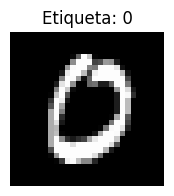

In [73]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"Etiqueta: {tags[y_train[idx][0]]}")
plt.show()

# Construcción del generador

In [74]:
def build_generator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label) # Capa de embedding para las etiquetas
    img_size_in = img_size // 4
    n_nodes = img_size_in * img_size_in
    li = Dense(n_nodes, name='Label_Dense')(li) # Capa densa para las etiquetas
    li = Reshape((img_size_in, img_size_in, 1), name='Label_Reshape')(li) # Cambio la forma de la capa

    in_lat = Input(shape=(noise_dim,), name='Latent_Input') # Capa de entrada de ruido
    n_nodes = 128 * img_size_in * img_size_in
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat) # Capa densa para el ruido
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_1')(gen)
    gen = Reshape((img_size_in, img_size_in, 128), name='Generator_Reshape')(gen)
    #---------------------------------------------------------------------------------#
    merge = Concatenate(name='Concatenate')([gen, li])
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 14x14x128
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_2')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 28x28x128
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_3')(gen)
    #---------------------------------------------------------------------------------#
    out_layer = Conv2D(3, (8, 8), activation='tanh', padding='same', name='Output_Conv2D')(gen)  # 28x28x3
    #---------------------------------------------------------------------------------#
    generator = Model([in_lat, in_label], out_layer, name='Generator')
    plot_model(generator, to_file='/content/drive/MyDrive/Lembo/generator_structure_m1.png', show_shapes=True, show_layer_names=True)

    return generator

# Construcción del discriminador

In [75]:
def build_discriminator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    n_nodes = img_size * img_size
    li = Dense(n_nodes, name='Label_Dense')(li)
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li)

    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input')
    merge = Concatenate(name='Concatenate')([in_image, li])
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same', name='Conv2D_1')(merge)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(fe) # 14x14x128
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same', name='Conv2D_2')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(fe) # 7x7x128
    #---------------------------------------------------------------------------------#
    fe = Flatten(name='Flatten')(fe)
    fe = Dropout(0.4, name='Dropout')(fe)
    #---------------------------------------------------------------------------------#
    out_layer = Dense(1, activation='sigmoid', name='Output')(fe)
    #---------------------------------------------------------------------------------#
    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    plot_model(discriminator, to_file='/content/drive/MyDrive/Lembo/discriminator_structure_m1.png', show_shapes=True, show_layer_names=True)

    return discriminator

# Función para visualizar el entrenamiento del generador

In [76]:
def show_samples(num_samples, noise_dim, g_model, epoch):

  fig, axes = plt.subplots(10,num_samples, figsize=(10,20))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=None)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([])
      axes[l,j].xaxis.set_ticks([])

      if j ==0:
        axes[l,j].set_ylabel(tags[l])

  os.makedirs("/content/drive/MyDrive/Lembo/evolution", exist_ok=True)
  plt.savefig(f"/content/drive/MyDrive/Lembo/evolution/digits_epoch={epoch}.png", bbox_inches='tight')
  plt.close(fig)

# Definición de las funciones de pérdida (loss)

In [77]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [78]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Entrenamiento de la CGAN

- Parámetros de entrenamiento

In [7]:
epoch_count = 20 # Cantidad de epocas
batch_size = 16 #tamaño del batch hay 60000/16 = 3750 batches
noise_dim = 100 # Dimension del ruido
lr = 0.0002 # Learning rate
n_class = len(tags)  # numero de clases

- Construyo el generador

In [80]:
g_optimizer = RMSprop(learning_rate=lr)
g_model = build_generator(noise_dim=noise_dim, n_class=n_class, img_size=img_size) # Construyo el generador
g_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Latent_Input (InputLayer)   [(None, 100)]                0         []                            
                                                                                                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Generator_Dense (Dense)     (None, 6272)                 633472    ['Latent_Input[0][0]']        
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                          

- Construyo el discriminador

In [81]:
d_optimizer = RMSprop(learning_rate=lr)
d_model = build_discriminator(n_class=n_class, noise_dim=noise_dim, img_size=img_size) # Construyo el discriminador
d_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                                  
 Label_Dense (Dense)         (None, 1, 784)               39984     ['Embedding[0][0]']           
                                                                                                  
 Image_Input (InputLayer)    [(None, 28, 28, 3)]          0         []                            
                                                                                      

- Paso de entrenamiento por batches para el conjunto de entrenamiento (se actualizan los pesos)

In [82]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch

        # Entreno el discriminador
        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([random_latent_vectors, real_labels]) #  Genero imagenes falsas

        with tf.GradientTape() as tape:
            pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
            pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales

            d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        # Extender las listas con las etiquetas correspondientes
        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas


        grads = tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes
        d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador

        # Entreno el generador
        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio

        with tf.GradientTape() as tape:
            fake_images = g_model([random_latent_vectors, real_labels]) # Genero imagenes falsas
            predictions = d_model([fake_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
            g_loss = generator_loss(predictions) # Calculo la loss del generador

        grads = tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
        g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador

    return d_loss, g_loss, all_real_labels, all_pred_labels

- Paso de entrenamiento por batches para el conjunto de entrenamiento (no se actualizan los pesos)

In [83]:
@tf.function # Compiles the test_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch

        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([random_latent_vectors, real_labels]) #  Genero imagenes falsas

        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales

        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        # Extender las listas con las etiquetas correspondientes
        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        fake_images = g_model([random_latent_vectors, real_labels]) # Genero imagenes falsas
        predictions = d_model([fake_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        g_loss = generator_loss(predictions) # Calculo la loss del generador

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [84]:
def train(train_dataset, test_dataset, epoch_count, batch_size):

    num_train_batches = len(train_dataset)
    num_test_batches = len(test_dataset)

    d_loss_list_epoch_train = np.zeros(epoch_count)
    g_loss_list_epoch_train = np.zeros(epoch_count)
    d_loss_list_epoch_test = np.zeros(epoch_count)
    g_loss_list_epoch_test = np.zeros(epoch_count)
    precision_list_epoch_train = np.zeros(epoch_count)
    recall_list_epoch_train = np.zeros(epoch_count)
    f1_list_epoch_train = np.zeros(epoch_count)
    accuracy_list_epoch_train = np.zeros(epoch_count)
    precision_list_epoch_test = np.zeros(epoch_count)
    recall_list_epoch_test = np.zeros(epoch_count)
    f1_list_epoch_test = np.zeros(epoch_count)
    accuracy_list_epoch_test = np.zeros(epoch_count)
    d_loss_list_itern_train = np.zeros(epoch_count *num_train_batches)
    g_loss_list_itern_train = np.zeros(epoch_count * num_train_batches)
    d_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)
    g_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)

    itern_train_counter = 0
    itern_test_counter = 0

    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)

        d_loss_list_batch_train_aux = np.zeros(num_train_batches)
        g_loss_list_batch_train_aux = np.zeros(num_train_batches)
        d_loss_list_batch_test_aux = np.zeros(num_test_batches)
        g_loss_list_batch_test_aux = np.zeros(num_test_batches)
        precision_list_batch_train = np.zeros(num_train_batches)
        recall_list_batch_train = np.zeros(num_train_batches)
        f1_list_batch_train = np.zeros(num_train_batches)
        accuracy_list_batch_train = np.zeros(num_train_batches)
        precision_list_batch_test = np.zeros(num_test_batches)
        recall_list_batch_test = np.zeros(num_test_batches)
        f1_list_batch_test = np.zeros(num_test_batches)
        accuracy_list_batch_test = np.zeros(num_test_batches)

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Train - batch/batches: "): # Itero sobre todos los batches para el conjunto de entrenamiento

            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_train_aux[itern] = d_loss_train
            g_loss_list_batch_train_aux[itern] = g_loss_train
            d_loss_list_itern_train[itern_train_counter] = d_loss_train
            g_loss_list_itern_train[itern_train_counter] = g_loss_train
            itern_train_counter += 1

            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,)) # Reshapeo para que all_pred_labels_train (tiene la dimensión de la salida del discriminador) tenga la misma forma que all_real_labels_train

            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_batch_train[itern] = precision_train
            recall_list_batch_train[itern] = recall_train
            f1_list_batch_train[itern] = f1_train
            accuracy_list_batch_train[itern] = accuracy_train
            itern=itern+1

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Test - batch/batches: "): # Itero sobre todos los batches para el conjunto de testeo

            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_test_aux[itern] = d_loss_test
            g_loss_list_batch_test_aux[itern] = g_loss_test
            d_loss_list_itern_test[itern_test_counter] = d_loss_test
            g_loss_list_itern_test[itern_test_counter] = g_loss_test
            itern_test_counter += 1

            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_batch_test[itern] = precision_test
            recall_list_batch_test[itern] = recall_test
            f1_list_batch_test[itern] = f1_test
            accuracy_list_batch_test[itern] = accuracy_test
            itern=itern+1

        d_loss_list_epoch_train[epoch] = np.mean(d_loss_list_batch_train_aux)
        g_loss_list_epoch_train[epoch] = np.mean(g_loss_list_batch_train_aux)
        d_loss_list_epoch_test[epoch] = np.mean(d_loss_list_batch_test_aux)
        g_loss_list_epoch_test[epoch] = np.mean(g_loss_list_batch_test_aux)
        precision_list_epoch_train[epoch] = np.mean(precision_list_batch_train)
        recall_list_epoch_train[epoch] = np.mean(recall_list_batch_train)
        f1_list_epoch_train[epoch] = np.mean(f1_list_batch_train)
        accuracy_list_epoch_train[epoch] = np.mean(accuracy_list_batch_train)
        precision_list_epoch_test[epoch] = np.mean(precision_list_batch_test)
        recall_list_epoch_test[epoch] = np.mean(recall_list_batch_test)
        f1_list_epoch_test[epoch] = np.mean(f1_list_batch_test)
        accuracy_list_epoch_test[epoch] = np.mean(accuracy_list_batch_test)

        print (f'Train - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_train_aux)}')
        print (f'Test - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_test_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_test_aux)}\n')
        print (f'Tomó {time.time()-start} segundos. \n\n')

        if epoch % 5 == 0:
            show_samples(4, noise_dim, g_model, epoch)

    return d_loss_list_itern_train, g_loss_list_itern_train, d_loss_list_itern_test, g_loss_list_itern_test, d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test

- Entrenamiento del modelo

In [85]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

d_loss_itern_train, g_loss_itern_train, d_loss_itern_test, g_loss_itern_test, d_loss_train, g_loss_train, d_loss_test, g_loss_test, precision_train, recall_train, f1_train, accuracy_train, precision_test, recall_test, f1_test, accuracy_test  = train(train_dataset, test_dataset, epoch_count, batch_size)
epochs = np.arange(1, epoch_count+1)

np.savez("/content/drive/MyDrive/Lembo/metricas_mnist_m1.npz", epochs= epochs, d_loss_itern_train=d_loss_itern_train, g_loss_itern_train=g_loss_itern_train, d_loss_itern_test=d_loss_itern_test, g_loss_itern_test=g_loss_itern_test, d_loss_train=d_loss_train, g_loss_train=g_loss_train, d_loss_test=d_loss_test, g_loss_test=g_loss_test, precision_train=precision_train, recall_train=recall_train, f1_train=f1_train, accuracy_train=accuracy_train, precision_test=precision_test, recall_test=recall_test, f1_test=f1_test, accuracy_test=accuracy_test)
g_model.save("/content/drive/MyDrive/Lembo/gmodel_mnist_m1.keras")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_mnist_m1.keras")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_mnist_m1.H5")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_mnist_m1.H5")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_mnist_m1.h5")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_mnist_m1.h5")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_mnist_m1.tf")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_mnist_m1.tf")

Epoch:  1


Test - batch/batches: 100%|██████████| 625/625 [00:09<00:00, 68.24it/s]


Train - Época: 1 -- Generator Loss: 1.0325370658397675, Discriminator Loss: 1.1387741129000981
Test - Época: 1 -- Generator Loss: 1.0013308417320252, Discriminator Loss: 1.0760738255500792

Tomó 103.81181693077087 segundos. 


1/1 [==============================] - 0s 26ms/step
Epoch:  2


Test - batch/batches: 100%|██████████| 625/625 [00:09<00:00, 63.27it/s]


Train - Época: 2 -- Generator Loss: 1.2134514642556509, Discriminator Loss: 1.0489531922499338
Test - Época: 2 -- Generator Loss: 1.94657231426239, Discriminator Loss: 1.0981837695121766

Tomó 86.3802797794342 segundos. 


Epoch:  3


Test - batch/batches: 100%|██████████| 625/625 [00:10<00:00, 60.36it/s]


Train - Época: 3 -- Generator Loss: 1.3646938027620314, Discriminator Loss: 0.99007454773585
Test - Época: 3 -- Generator Loss: 1.1473212468147278, Discriminator Loss: 0.9576782769203186

Tomó 86.77141213417053 segundos. 


Epoch:  4


Test - batch/batches: 100%|██████████| 625/625 [00:10<00:00, 60.85it/s]


Train - Época: 4 -- Generator Loss: 1.6272209771235784, Discriminator Loss: 0.8546805994113287
Test - Época: 4 -- Generator Loss: 2.389281463241577, Discriminator Loss: 0.8309904436588287

Tomó 86.18650960922241 segundos. 


Epoch:  5


Test - batch/batches: 100%|██████████| 625/625 [00:10<00:00, 61.66it/s]


Train - Época: 5 -- Generator Loss: 1.9820864770650863, Discriminator Loss: 0.7262495803435643
Test - Época: 5 -- Generator Loss: 1.7001171728134155, Discriminator Loss: 0.5505678214073181

Tomó 92.05769515037537 segundos. 


Epoch:  6


Test - batch/batches: 100%|██████████| 625/625 [00:09<00:00, 63.91it/s]


Train - Época: 6 -- Generator Loss: 2.1714421581586203, Discriminator Loss: 0.700118441482385
Test - Época: 6 -- Generator Loss: 2.9906119148254393, Discriminator Loss: 0.5640789754390717

Tomó 84.63851881027222 segundos. 


1/1 [==============================] - 0s 18ms/step
Epoch:  7


Test - batch/batches: 100%|██████████| 625/625 [00:09<00:00, 63.60it/s]


Train - Época: 7 -- Generator Loss: 2.2664858383814495, Discriminator Loss: 0.6956710529009501
Test - Época: 7 -- Generator Loss: 0.9723925271987915, Discriminator Loss: 0.9176814771652222

Tomó 84.83344078063965 segundos. 


Epoch:  8


Test - batch/batches: 100%|██████████| 625/625 [00:09<00:00, 63.36it/s]


Train - Época: 8 -- Generator Loss: 2.3670667592684427, Discriminator Loss: 0.6801753437916438
Test - Época: 8 -- Generator Loss: 1.547804214477539, Discriminator Loss: 0.5724813460826874

Tomó 84.12258291244507 segundos. 


Epoch:  9


Test - batch/batches: 100%|██████████| 625/625 [00:09<00:00, 64.63it/s]


Train - Época: 9 -- Generator Loss: 2.4315304649353027, Discriminator Loss: 0.6821652541240056
Test - Época: 9 -- Generator Loss: 1.6038799030303954, Discriminator Loss: 0.6687108095645905

Tomó 84.99002814292908 segundos. 


Epoch:  10


Test - batch/batches: 100%|██████████| 625/625 [00:10<00:00, 60.63it/s]


Train - Época: 10 -- Generator Loss: 2.5012279529651007, Discriminator Loss: 0.6778881535649299
Test - Época: 10 -- Generator Loss: 2.1899584829330445, Discriminator Loss: 0.5205264120340347

Tomó 92.22866201400757 segundos. 


Epoch:  11


Test - batch/batches: 100%|██████████| 625/625 [00:10<00:00, 61.13it/s]


Train - Época: 11 -- Generator Loss: 2.568068334945043, Discriminator Loss: 0.6639677121837934
Test - Época: 11 -- Generator Loss: 0.8352014316558838, Discriminator Loss: 1.0108412133216857

Tomó 86.71607422828674 segundos. 


1/1 [==============================] - 0s 18ms/step
Epoch:  12


Test - batch/batches: 100%|██████████| 625/625 [00:10<00:00, 61.14it/s]


Train - Época: 12 -- Generator Loss: 2.628654558054606, Discriminator Loss: 0.6540363289117813
Test - Época: 12 -- Generator Loss: 2.218355227279663, Discriminator Loss: 0.478676894903183

Tomó 87.54091882705688 segundos. 


Epoch:  13


Test - batch/batches: 100%|██████████| 625/625 [00:10<00:00, 62.48it/s]


Train - Época: 13 -- Generator Loss: 2.674887002670765, Discriminator Loss: 0.6563189786871274
Test - Época: 13 -- Generator Loss: 3.062565744781494, Discriminator Loss: 0.5080113845825195

Tomó 86.4605176448822 segundos. 


Epoch:  14


Test - batch/batches: 100%|██████████| 625/625 [00:10<00:00, 61.13it/s]


Train - Época: 14 -- Generator Loss: 2.666417544555664, Discriminator Loss: 0.6630282291213672
Test - Época: 14 -- Generator Loss: 1.8723628751754762, Discriminator Loss: 0.5034878962516784

Tomó 92.14170622825623 segundos. 


Epoch:  15


Test - batch/batches: 100%|██████████| 625/625 [00:08<00:00, 70.19it/s]


Train - Época: 15 -- Generator Loss: 2.688798491803805, Discriminator Loss: 0.649407628218333
Test - Época: 15 -- Generator Loss: 1.8971044361114502, Discriminator Loss: 0.5950853140115738

Tomó 90.82462358474731 segundos. 


Epoch:  16


Test - batch/batches: 100%|██████████| 625/625 [00:10<00:00, 59.86it/s]


Train - Época: 16 -- Generator Loss: 2.74730055975914, Discriminator Loss: 0.6549432098944982
Test - Época: 16 -- Generator Loss: 1.8736282538414002, Discriminator Loss: 0.473482924079895

Tomó 92.36403584480286 segundos. 


1/1 [==============================] - 0s 19ms/step
Epoch:  17


Test - batch/batches: 100%|██████████| 625/625 [00:08<00:00, 71.07it/s]


Train - Época: 17 -- Generator Loss: 2.752023061132431, Discriminator Loss: 0.6519094693044821
Test - Época: 17 -- Generator Loss: 2.60922509765625, Discriminator Loss: 0.43811354784965517

Tomó 86.11493301391602 segundos. 


Epoch:  18


Test - batch/batches: 100%|██████████| 625/625 [00:20<00:00, 30.54it/s]


Train - Época: 18 -- Generator Loss: 2.7575526444594067, Discriminator Loss: 0.6524579214453697
Test - Época: 18 -- Generator Loss: 2.062779373931885, Discriminator Loss: 0.4530862246751785

Tomó 102.38293051719666 segundos. 


Epoch:  19


Test - batch/batches: 100%|██████████| 625/625 [00:09<00:00, 64.31it/s]


Train - Época: 19 -- Generator Loss: 2.7453960675199824, Discriminator Loss: 0.6612899931550026
Test - Época: 19 -- Generator Loss: 3.3725286220550537, Discriminator Loss: 0.6323003041028976

Tomó 86.4107894897461 segundos. 


Epoch:  20


Test - batch/batches: 100%|██████████| 625/625 [00:08<00:00, 72.05it/s]


Train - Época: 20 -- Generator Loss: 2.7635810374935468, Discriminator Loss: 0.6545724854071935
Test - Época: 20 -- Generator Loss: 1.719168639087677, Discriminator Loss: 0.7754328227043152

Tomó 85.69503378868103 segundos. 




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Graficas de la pérdida para el generador y el discriminador en función del número de iteraciones

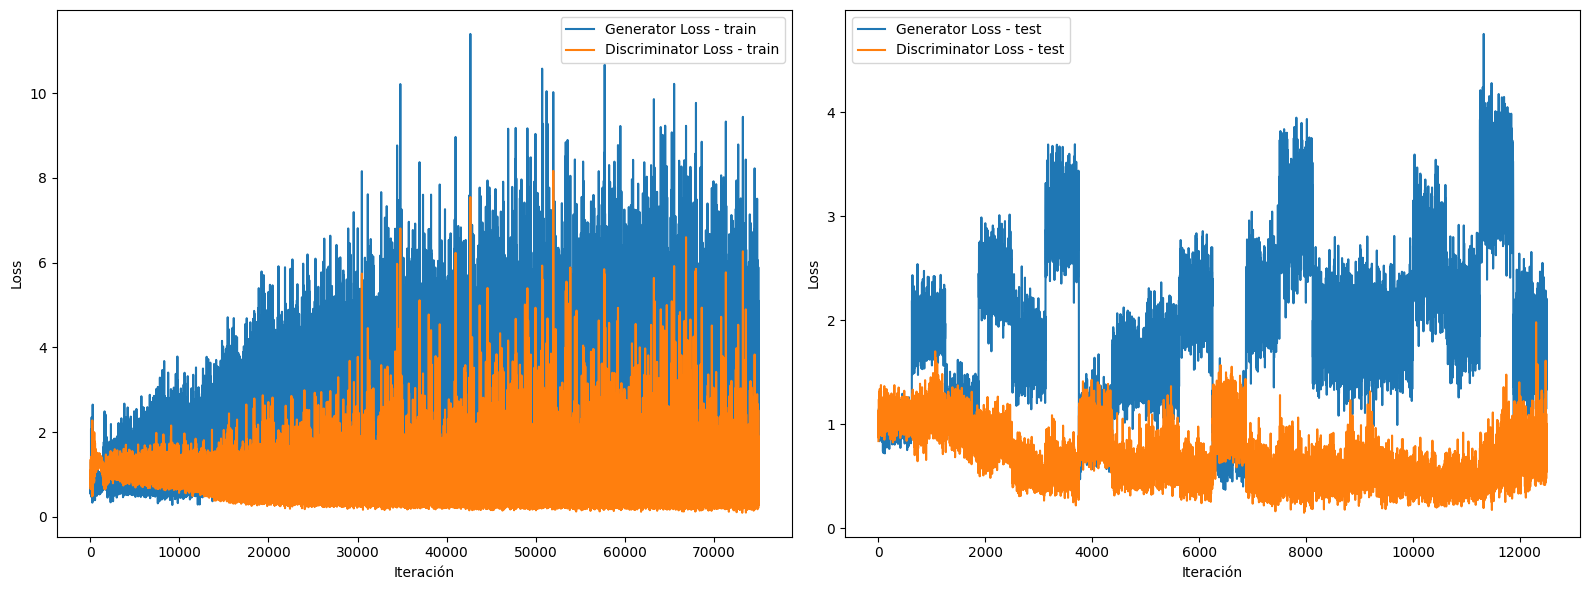

In [86]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_mnist_m1.npz")

iteration_train = np.arange(1, len(X_train)/batch_size*epoch_count+1)
iteration_test = np.arange(1, len(X_test)/batch_size*epoch_count+1)
d_loss_train = data['d_loss_itern_train']
g_loss_train = data['g_loss_itern_train']
d_loss_test = data['d_loss_itern_test']
g_loss_test = data['g_loss_itern_test']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(iteration_train, g_loss_itern_train, label='Generator Loss - train')
axs[0].plot(iteration_train, d_loss_itern_train, label='Discriminator Loss - train')
axs[0].set_xlabel('Iteración')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(iteration_test, g_loss_itern_test, label='Generator Loss - test')
axs[1].plot(iteration_test, d_loss_itern_test, label='Discriminator Loss - test')
axs[1].set_xlabel('Iteración')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

# Graficas de la pérdida para el generador y el discriminador en función de las épocas

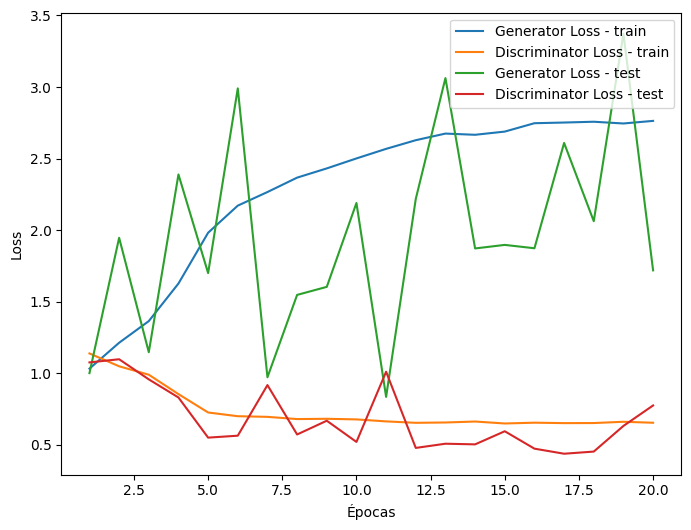

In [87]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_mnist_m1.npz")
epochs = data['epochs']
d_loss_train = data['d_loss_train']
g_loss_train = data['g_loss_train']
d_loss_test = data['d_loss_test']
g_loss_test = data['g_loss_test']

plt.figure(figsize=(8,6))
epochs = np.arange(1, epoch_count+1)
plt.plot(epochs, g_loss_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_test, label='Discriminator Loss - test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficas de las métricas para el discriminador en función del número de épocas

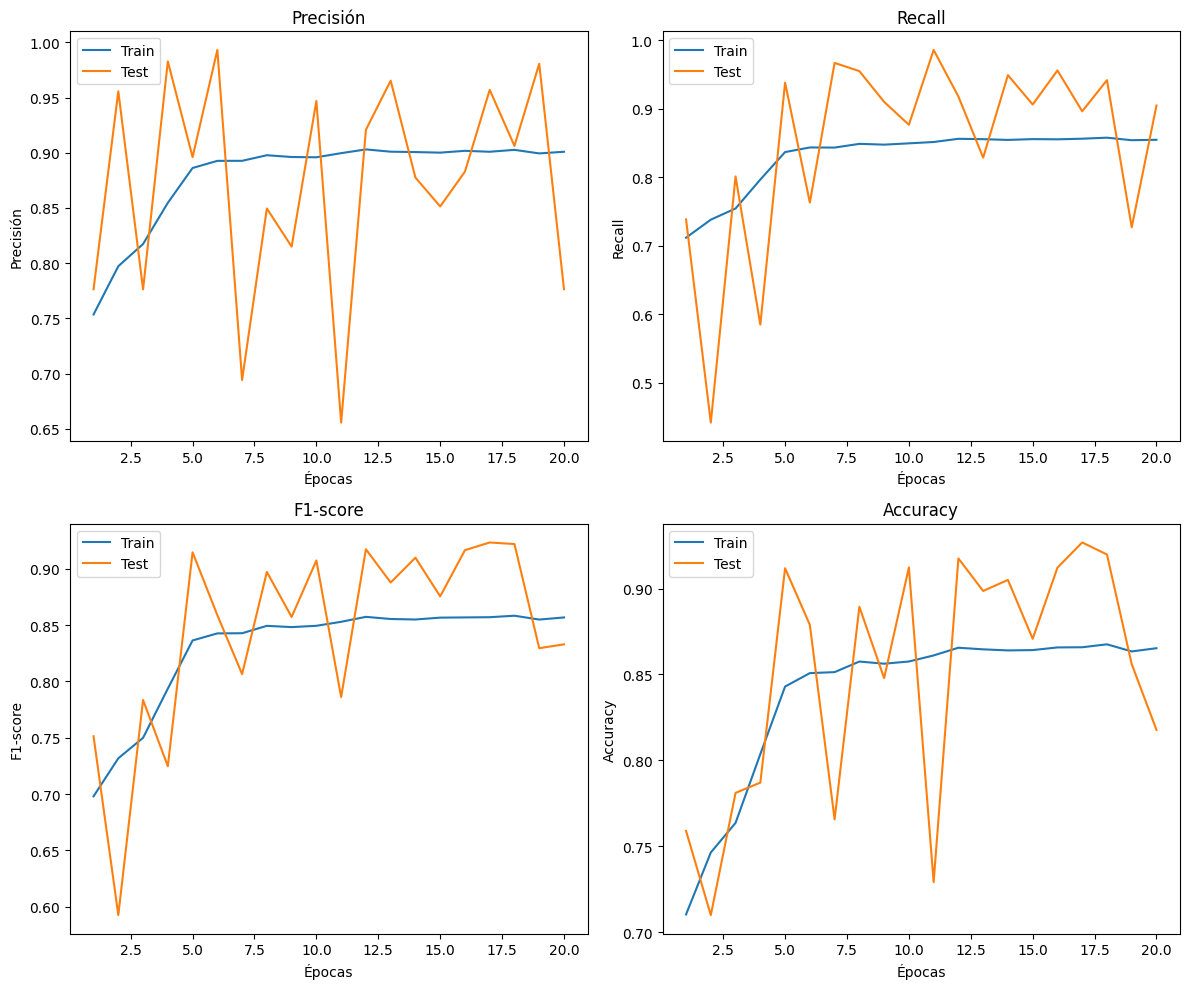

In [88]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_mnist_m1.npz")

epochs = data['epochs']
precision_train = data['precision_train']
recall_train = data['recall_train']
f1_train = data['f1_train']
accuracy_train = data['accuracy_train']
precision_test = data['precision_test']
recall_test = data['recall_test']
f1_test = data['f1_test']
accuracy_test = data['accuracy_test']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
epochs = np.arange(1, epoch_count + 1)
axs[0, 0].plot(epochs, precision_train, label='Train')
axs[0, 0].plot(epochs, precision_test, label='Test')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].legend()
axs[0, 0].set_title('Precisión')
axs[0, 1].plot(epochs, recall_train, label='Train')
axs[0, 1].plot(epochs, recall_test, label='Test')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].set_title('Recall')
axs[1, 0].plot(epochs, f1_train, label='Train')
axs[1, 0].plot(epochs, f1_test, label='Test')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('F1-score')
axs[1, 0].legend()
axs[1, 0].set_title('F1-score')
axs[1, 1].plot(epochs, accuracy_train, label='Train')
axs[1, 1].plot(epochs, accuracy_test, label='Test')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].set_title('Accuracy')
plt.tight_layout()
plt.show()

# Generación de un dígito pedido por el usuario

Tamaño imagen generada:  (1, 28, 28, 3)


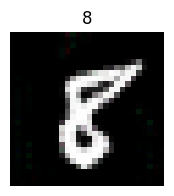

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image

noise_dim = 100 # Dimension del ruido

# Cargar el modelo generador
g_model = load_model('gmodel_mnist_m1.h5')

numero_a_generar = 8

#label = tf.expand_dims(numero_a_generar, axis=-1) #expando la dimension de y_train para que quede analogo al ejemplo del cifar10
label = tf.ones(1)*numero_a_generar

# Generar ruido aleatorio
noise = tf.random.normal(shape=(1, noise_dim))

# Generar imagen falsa
generated_image = g_model([noise, label]) #  Genero imagenes falsas
#generated_image = g_model.predict([noise, label])
print("Tamaño imagen generada: ", generated_image.shape)

plt.figure(figsize=(2,2))
img = image.array_to_img(generated_image[0], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"{numero_a_generar}")
plt.show()